## A CARMA Model using TinyGP and Numpyro

I'm going to do simulated data from scratch, and then see if I can sample that model using NUTS or Nested SAmpling in Numpyro:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import pickle
import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA

from jaxns.utils import resample

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import _skew_gaussian

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.nested_sampling import NestedSampler

import arviz as az

INFO[2023-10-18 10:44:30,037]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1697618670.035273       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-18 10:44:30,038]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-18 10:44:30,047]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

## Test 1: A CARMA light curve without mean function

Let's first simulate a CARMA light curve without mean function:

[1.11808768 1.16957863 0.81403688 ... 1.75202262 1.91635652 1.72027993]


INFO[2023-10-18 10:44:49,592]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-18 10:44:49,757]: Checking if light curve is sorted.


679.4775210344745


INFO[2023-10-18 10:44:49,863]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


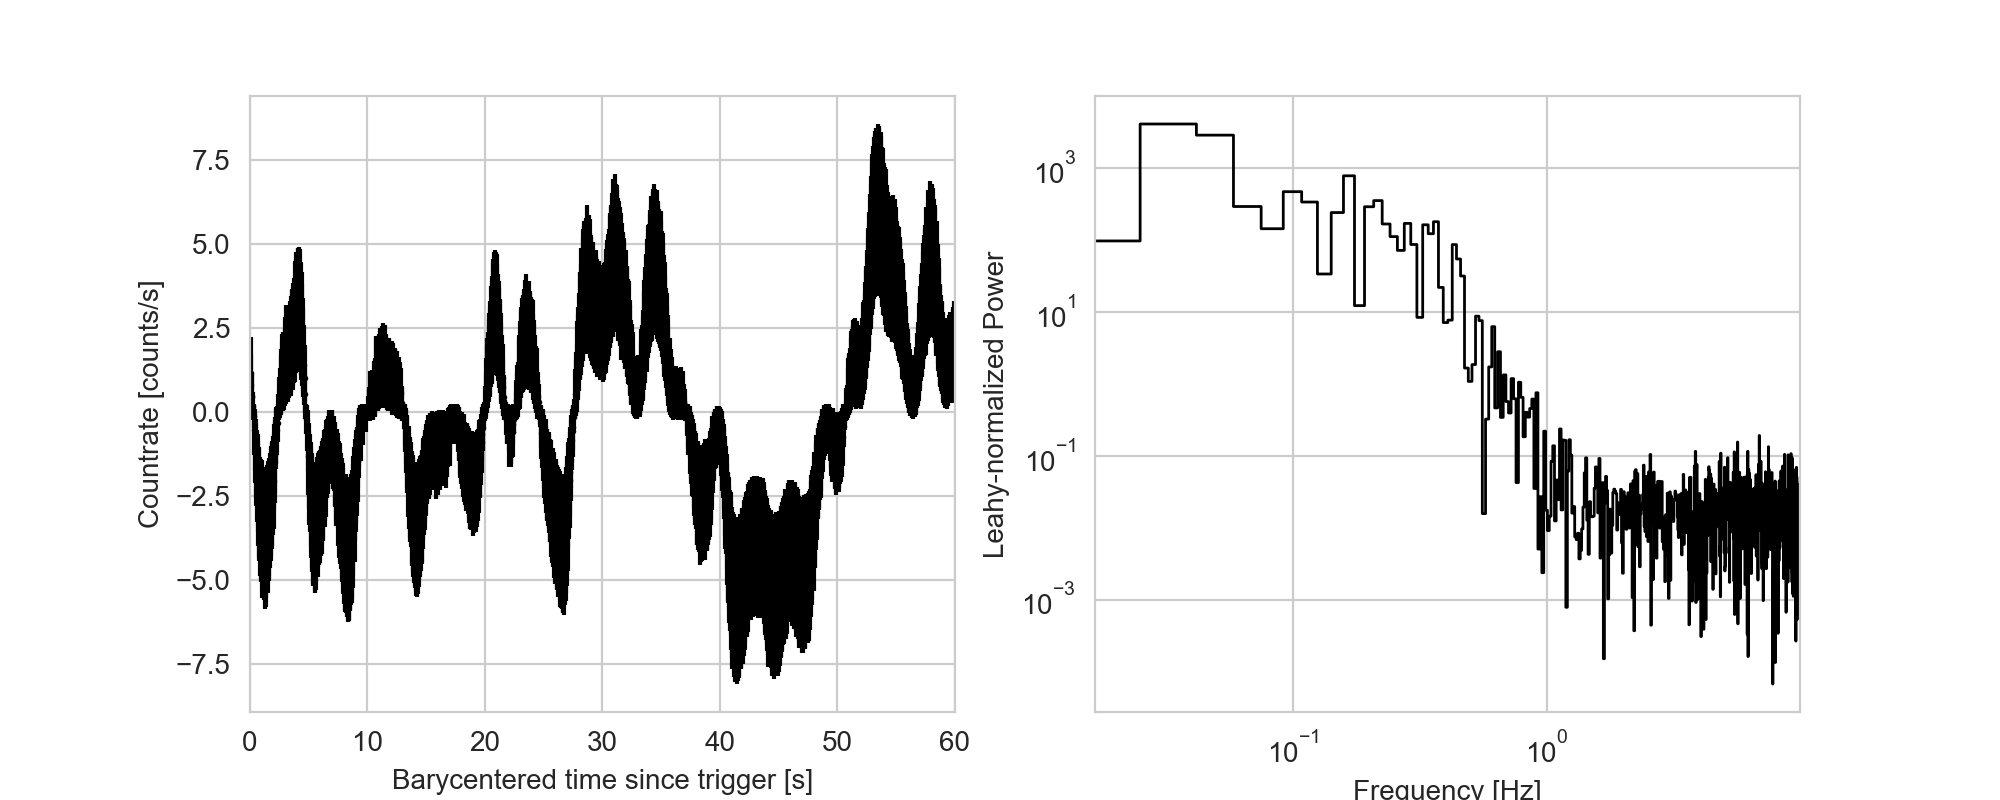

<IPython.core.display.Javascript object>


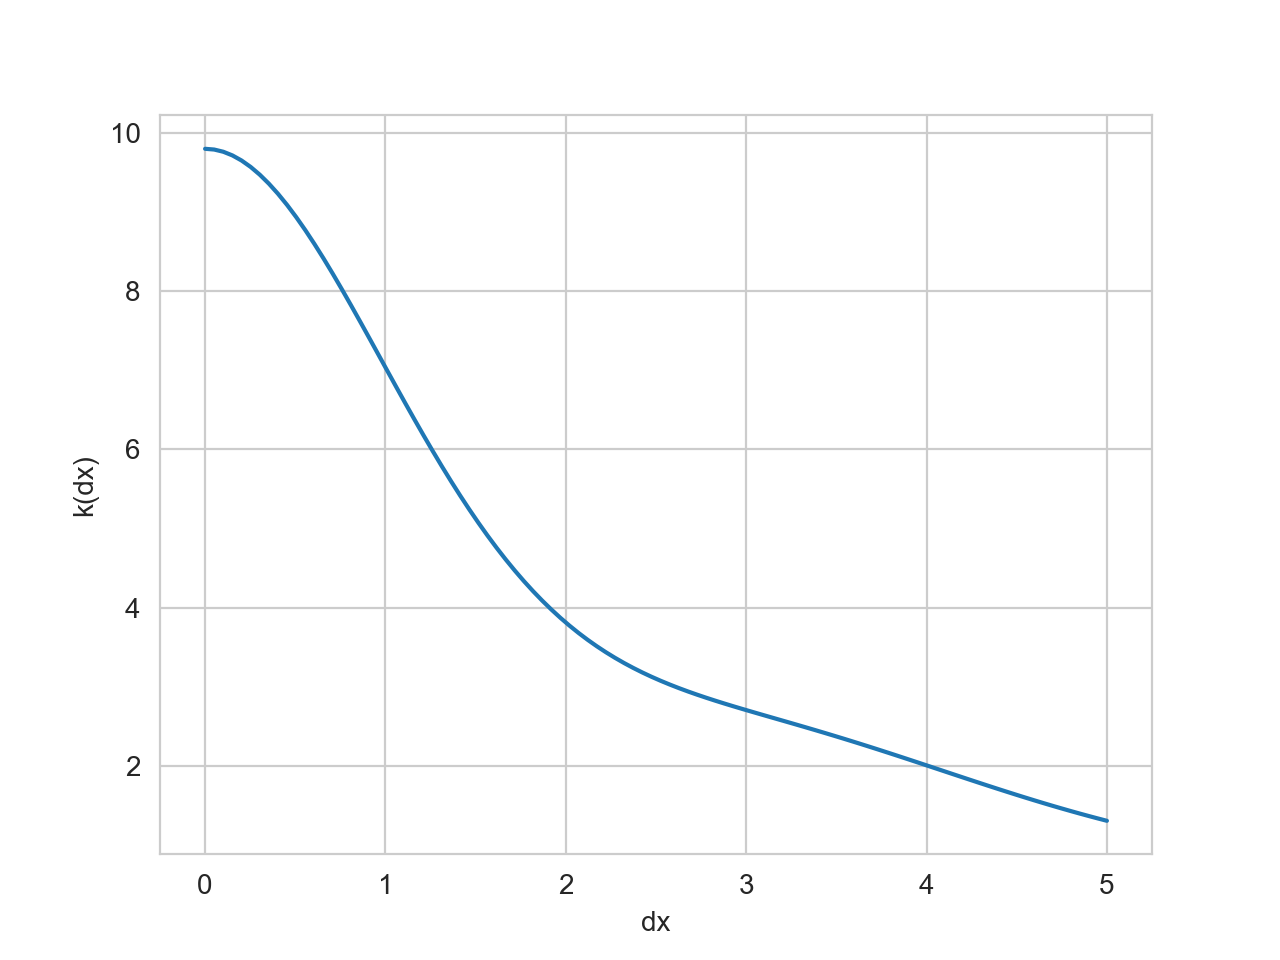

In [2]:
dt = 0.05
tseg = 60.0

time = np.linspace(0, 60, int(60/0.05))

alpha = [1.5, 4.5, 2.0]
beta = [10.5]
sigma = 4.0

mean_val = 100.0

#kernel_params_true = {"alpha": alpha,
#                      "beta": beta,
#                      "acarma": sigma}

kernel_params_true = np.hstack([alpha, beta, sigma])

kernel = CARMA.init(alpha=alpha, beta=beta)
gp = GaussianProcess(kernel, time, diag=0.01)

key = random.PRNGKey(1200)
sample = gp.sample(key)# + mean_val
#sample = np.random.poisson(sample)
print(sample)
gp.condition(sample)
print(gp.log_probability(sample))

lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="frac")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

### Nested Sampling in Numpyro

In [3]:
def model(t, y=None):

    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-1, 2.5))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-1, 2.5))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-1, 2.5))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-1, 2.5))
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(0, 5.3))
    
    log_mean = numpyro.sample("log_mean", dist.Uniform(0, 5.3))
    
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
                        beta=[jnp.exp(log_beta)], sigma=jnp.exp(log_sigma))
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=jnp.ones_like(t) * jnp.exp(log_mean))
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [4]:
npoints = len(lcsample.time)
ns = NestedSampler(model)
ns.run(random.PRNGKey(2), lcsample.time[:npoints], y=lcsample.counts[:npoints])

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(2068): _wrapped_callback
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1141): __call__
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/pjit.py(1154): _pjit_call_impl_python
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/pjit.py(1198): call_impl_cache_miss
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/pjit.py(1214): _pjit_call_impl
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/core.py(821): process_primitive
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/core.py(389): bind_with_trace
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/core.py(2604): bind
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/pjit.py(166): _python_pjit_helper
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/pjit.py(255): cache_miss
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jax/_src/traceback_util.py(177): reraise_with_filtered_traceback
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jaxns/nested_sampler.py(342): __call__
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/jaxns/nested_sampler.py(409): __call__
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/numpyro/contrib/nested_sampling.py(285): run
  /var/folders/cm/2d1tk8fs125435tgbw22nb0h0000gp/T/ipykernel_53529/2961492196.py(3): <module>
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3526): run_code
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3466): run_ast_nodes
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3284): run_cell_async
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3079): _run_cell
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3024): run_cell
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/zmqshell.py(546): run_cell
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/kernelbase.py(740): execute_request
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/kernelbase.py(412): dispatch_shell
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/kernelbase.py(505): process_one
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/kernelbase.py(516): dispatch_queue
  /opt/miniconda3/envs/grbsearch/lib/python3.10/asyncio/events.py(80): _run
  /opt/miniconda3/envs/grbsearch/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /opt/miniconda3/envs/grbsearch/lib/python3.10/asyncio/base_events.py(603): run_forever
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/tornado/platform/asyncio.py(195): start
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel/kernelapp.py(736): start
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/traitlets/config/application.py(992): launch_instance
  /opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /opt/miniconda3/envs/grbsearch/lib/python3.10/runpy.py(86): _run_code
  /opt/miniconda3/envs/grbsearch/lib/python3.10/runpy.py(196): _run_module_as_main


In [146]:
ns.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 159575
# samples: 2700
# slices: 37800.0
# slices / acceptance: 18.0
# likelihood evals / sample: 59.1
# likelihood evals / slice: 4.1
--------
logZ=-4612.14 +- 0.26
H=4600.0
ESS=460
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 1.29 +- 0.46 | 0.65 / 1.37 / 1.78 | 1.48 | 1.48
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 1.71 +- 0.16 | 1.53 / 1.71 / 1.92 | 1.7 | 1.7
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 0.69 +- 0.37 | 0.18 / 0.72 / 1.09 | 0.76 | 0.76
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 1.51 +- 0.64 | 0.59 / 1.61 / 2.32 | 0.61 | 0.61
--------
log_mean: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_mean: 4.58 +- 0.065 | 4.502 / 4.584 / 4.663 

pred[149]: 0.8 +- 6.3 | -7.4 / 0.5 / 8.3 | 1.2 | 1.2
pred[150]: -1.8 +- 6.3 | -10.0 / -2.0 / 5.7 | -1.4 | -1.4
pred[151]: -4.5 +- 6.3 | -12.7 / -4.8 / 3.0 | -4.1 | -4.1
pred[152]: -7.4 +- 6.3 | -15.6 / -7.6 / 0.1 | -7.0 | -7.0
pred[153]: -10.4 +- 6.3 | -18.6 / -10.6 / -2.9 | -10.0 | -10.0
pred[154]: -13.5 +- 6.3 | -21.8 / -13.7 / -6.0 | -13.1 | -13.1
pred[155]: -16.7 +- 6.3 | -25.0 / -16.8 / -9.1 | -16.3 | -16.3
pred[156]: -19.9 +- 6.3 | -28.2 / -20.0 / -12.3 | -19.5 | -19.5
pred[157]: -23.1 +- 6.3 | -31.5 / -23.3 / -15.6 | -22.7 | -22.7
pred[158]: -26.3 +- 6.3 | -34.7 / -26.5 / -18.8 | -25.9 | -25.9
pred[159]: -29.4 +- 6.3 | -37.8 / -29.6 / -21.9 | -29.0 | -29.0
pred[160]: -32.4 +- 6.3 | -40.8 / -32.6 / -24.9 | -32.0 | -32.0
pred[161]: -35.2 +- 6.3 | -43.7 / -35.5 / -27.8 | -34.8 | -34.8
pred[162]: -37.9 +- 6.3 | -46.3 / -38.1 / -30.4 | -37.5 | -37.5
pred[163]: -40.4 +- 6.3 | -48.7 / -40.5 / -32.8 | -40.0 | -40.0
pred[164]: -42.5 +- 6.3 | -50.8 / -42.7 / -35.0 | -42.1 | -42.1
pred[165

pred[360]: -3.2 +- 6.3 | -11.3 / -3.3 / 4.3 | -2.8 | -2.8
pred[361]: -4.6 +- 6.3 | -12.8 / -4.9 / 2.8 | -4.2 | -4.2
pred[362]: -6.1 +- 6.3 | -14.3 / -6.4 / 1.3 | -5.7 | -5.7
pred[363]: -7.6 +- 6.3 | -15.8 / -7.8 / -0.2 | -7.2 | -7.2
pred[364]: -9.1 +- 6.3 | -17.3 / -9.3 / -1.7 | -8.7 | -8.7
pred[365]: -10.5 +- 6.3 | -18.7 / -10.8 / -3.1 | -10.1 | -10.1
pred[366]: -11.9 +- 6.3 | -20.1 / -12.1 / -4.5 | -11.5 | -11.5
pred[367]: -13.2 +- 6.3 | -21.4 / -13.5 / -5.8 | -12.8 | -12.8
pred[368]: -14.5 +- 6.3 | -22.6 / -14.7 / -7.0 | -14.1 | -14.1
pred[369]: -15.6 +- 6.3 | -23.8 / -15.9 / -8.2 | -15.2 | -15.2
pred[370]: -16.7 +- 6.3 | -24.9 / -16.9 / -9.2 | -16.3 | -16.3
pred[371]: -17.6 +- 6.3 | -25.9 / -17.8 / -10.1 | -17.3 | -17.3
pred[372]: -18.5 +- 6.3 | -26.8 / -18.7 / -11.0 | -18.1 | -18.1
pred[373]: -19.3 +- 6.3 | -27.6 / -19.5 / -11.8 | -18.9 | -18.9
pred[374]: -20.0 +- 6.3 | -28.2 / -20.1 / -12.5 | -19.6 | -19.6
pred[375]: -20.5 +- 6.3 | -28.8 / -20.7 / -13.0 | -20.2 | -20.2
pred[376]:

pred[549]: 6.6 +- 6.3 | -1.6 / 6.4 / 14.1 | 7.0 | 7.0
pred[550]: 10.7 +- 6.3 | 2.4 / 10.5 / 18.2 | 11.1 | 11.1
pred[551]: 14.7 +- 6.3 | 6.5 / 14.6 / 22.3 | 15.2 | 15.2
pred[552]: 18.8 +- 6.3 | 10.5 / 18.6 / 26.4 | 19.2 | 19.2
pred[553]: 22.9 +- 6.3 | 14.5 / 22.6 / 30.4 | 23.3 | 23.3
pred[554]: 26.8 +- 6.3 | 18.4 / 26.6 / 34.3 | 27.2 | 27.2
pred[555]: 30.6 +- 6.3 | 22.2 / 30.5 / 38.1 | 31.0 | 31.0
pred[556]: 34.3 +- 6.3 | 25.9 / 34.1 / 41.7 | 34.7 | 34.7
pred[557]: 37.8 +- 6.3 | 29.4 / 37.6 / 45.3 | 38.2 | 38.2
pred[558]: 41.1 +- 6.3 | 32.7 / 40.9 / 48.6 | 41.5 | 41.5
pred[559]: 44.2 +- 6.3 | 35.8 / 44.0 / 51.8 | 44.5 | 44.5
pred[560]: 47.0 +- 6.3 | 38.7 / 46.8 / 54.6 | 47.4 | 47.4
pred[561]: 49.6 +- 6.3 | 41.4 / 49.4 / 57.2 | 50.0 | 50.0
pred[562]: 52.0 +- 6.3 | 43.8 / 51.8 / 59.6 | 52.4 | 52.4
pred[563]: 54.1 +- 6.3 | 46.0 / 54.0 / 61.7 | 54.5 | 54.5
pred[564]: 56.0 +- 6.3 | 48.0 / 55.8 / 63.6 | 56.4 | 56.4
pred[565]: 57.7 +- 6.3 | 49.6 / 57.5 / 65.2 | 58.1 | 58.1
pred[566]: 59.1 +- 6

pred[772]: -30.4 +- 6.3 | -38.7 / -30.6 / -22.9 | -30.0 | -30.0
pred[773]: -29.3 +- 6.3 | -37.8 / -29.5 / -21.9 | -28.9 | -28.9
pred[774]: -28.1 +- 6.3 | -36.6 / -28.3 / -20.7 | -27.7 | -27.7
pred[775]: -26.8 +- 6.3 | -35.4 / -27.0 / -19.5 | -26.4 | -26.4
pred[776]: -25.4 +- 6.3 | -33.9 / -25.6 / -18.2 | -25.0 | -25.0
pred[777]: -24.0 +- 6.3 | -32.4 / -24.1 / -16.7 | -23.6 | -23.6
pred[778]: -22.5 +- 6.3 | -30.9 / -22.6 / -15.2 | -22.1 | -22.1
pred[779]: -20.9 +- 6.3 | -29.3 / -21.1 / -13.6 | -20.5 | -20.5
pred[780]: -19.4 +- 6.3 | -27.8 / -19.5 / -12.0 | -19.0 | -19.0
pred[781]: -17.8 +- 6.3 | -26.3 / -18.0 / -10.2 | -17.4 | -17.4
pred[782]: -16.2 +- 6.3 | -24.5 / -16.4 / -8.6 | -15.8 | -15.8
pred[783]: -14.5 +- 6.3 | -22.8 / -14.7 / -7.0 | -14.1 | -14.1
pred[784]: -12.8 +- 6.3 | -20.9 / -13.0 / -5.3 | -12.4 | -12.4
pred[785]: -11.0 +- 6.3 | -19.1 / -11.3 / -3.5 | -10.6 | -10.6
pred[786]: -9.1 +- 6.3 | -17.2 / -9.4 / -1.7 | -8.7 | -8.7
pred[787]: -7.2 +- 6.3 | -15.2 / -7.6 / 0.3 | -6.

pred[978]: 26.6 +- 6.3 | 18.2 / 26.5 / 34.1 | 27.0 | 27.0
pred[979]: 27.2 +- 6.3 | 18.7 / 27.0 / 34.7 | 27.5 | 27.5
pred[980]: 27.3 +- 6.3 | 18.9 / 27.2 / 34.8 | 27.7 | 27.7
pred[981]: 27.1 +- 6.3 | 18.7 / 27.0 / 34.6 | 27.5 | 27.5
pred[982]: 26.6 +- 6.3 | 18.2 / 26.5 / 34.1 | 27.0 | 27.0
pred[983]: 25.7 +- 6.3 | 17.4 / 25.6 / 33.3 | 26.1 | 26.1
pred[984]: 24.6 +- 6.3 | 16.3 / 24.5 / 32.1 | 25.0 | 25.0
pred[985]: 23.2 +- 6.3 | 15.0 / 23.1 / 30.7 | 23.6 | 23.6
pred[986]: 21.6 +- 6.3 | 13.5 / 21.4 / 29.1 | 22.0 | 22.0
pred[987]: 19.9 +- 6.3 | 11.8 / 19.7 / 27.4 | 20.3 | 20.3
pred[988]: 18.0 +- 6.3 | 9.9 / 17.9 / 25.5 | 18.5 | 18.5
pred[989]: 16.2 +- 6.3 | 8.1 / 15.9 / 23.6 | 16.6 | 16.6
pred[990]: 14.2 +- 6.3 | 6.2 / 14.0 / 21.7 | 14.7 | 14.7
pred[991]: 12.3 +- 6.3 | 4.3 / 12.1 / 19.8 | 12.8 | 12.8
pred[992]: 10.5 +- 6.3 | 2.4 / 10.2 / 17.9 | 10.9 | 10.9
pred[993]: 8.7 +- 6.3 | 0.5 / 8.4 / 16.1 | 9.1 | 9.1
pred[994]: 6.9 +- 6.3 | -1.2 / 6.7 / 14.4 | 7.3 | 7.3
pred[995]: 5.3 +- 6.3 | -2.9

pred[1173]: 25.0 +- 6.3 | 16.8 / 24.9 / 32.5 | 25.4 | 25.4
pred[1174]: 21.5 +- 6.2 | 13.3 / 21.3 / 29.0 | 21.8 | 21.8
pred[1175]: 17.9 +- 6.2 | 9.7 / 17.6 / 25.4 | 18.2 | 18.2
pred[1176]: 14.3 +- 6.2 | 6.2 / 14.1 / 21.8 | 14.7 | 14.7
pred[1177]: 10.9 +- 6.2 | 2.8 / 10.6 / 18.3 | 11.2 | 11.2
pred[1178]: 7.6 +- 6.2 | -0.5 / 7.3 / 14.9 | 7.9 | 7.9
pred[1179]: 4.4 +- 6.3 | -3.6 / 4.1 / 11.8 | 4.8 | 4.8
pred[1180]: 1.6 +- 6.3 | -6.4 / 1.3 / 8.9 | 2.0 | 2.0
pred[1181]: -1.0 +- 6.3 | -9.0 / -1.3 / 6.3 | -0.6 | -0.6
pred[1182]: -3.3 +- 6.3 | -11.3 / -3.6 / 4.1 | -2.9 | -2.9
pred[1183]: -5.2 +- 6.3 | -13.3 / -5.5 / 2.2 | -4.8 | -4.8
pred[1184]: -6.8 +- 6.3 | -14.9 / -7.1 / 0.7 | -6.4 | -6.4
pred[1185]: -8.0 +- 6.3 | -16.2 / -8.3 / -0.5 | -7.6 | -7.6
pred[1186]: -8.9 +- 6.3 | -17.1 / -9.2 / -1.4 | -8.5 | -8.5
pred[1187]: -9.5 +- 6.3 | -17.9 / -9.8 / -1.9 | -9.1 | -9.1
pred[1188]: -9.8 +- 6.3 | -18.2 / -10.0 / -2.2 | -9.4 | -9.4
pred[1189]: -9.8 +- 6.3 | -18.4 / -10.1 / -2.3 | -9.5 | -9.5
pred[11

In [147]:
ns.print_summary()
samples, weights = ns.get_weighted_samples()
#samples = ns.get_samples(random.PRNGKey(3), num_samples=5000)


In [154]:
kernel_params_true = np.hstack([kernel_params_true, jnp.log(mean_val)])

<IPython.core.display.Javascript object>


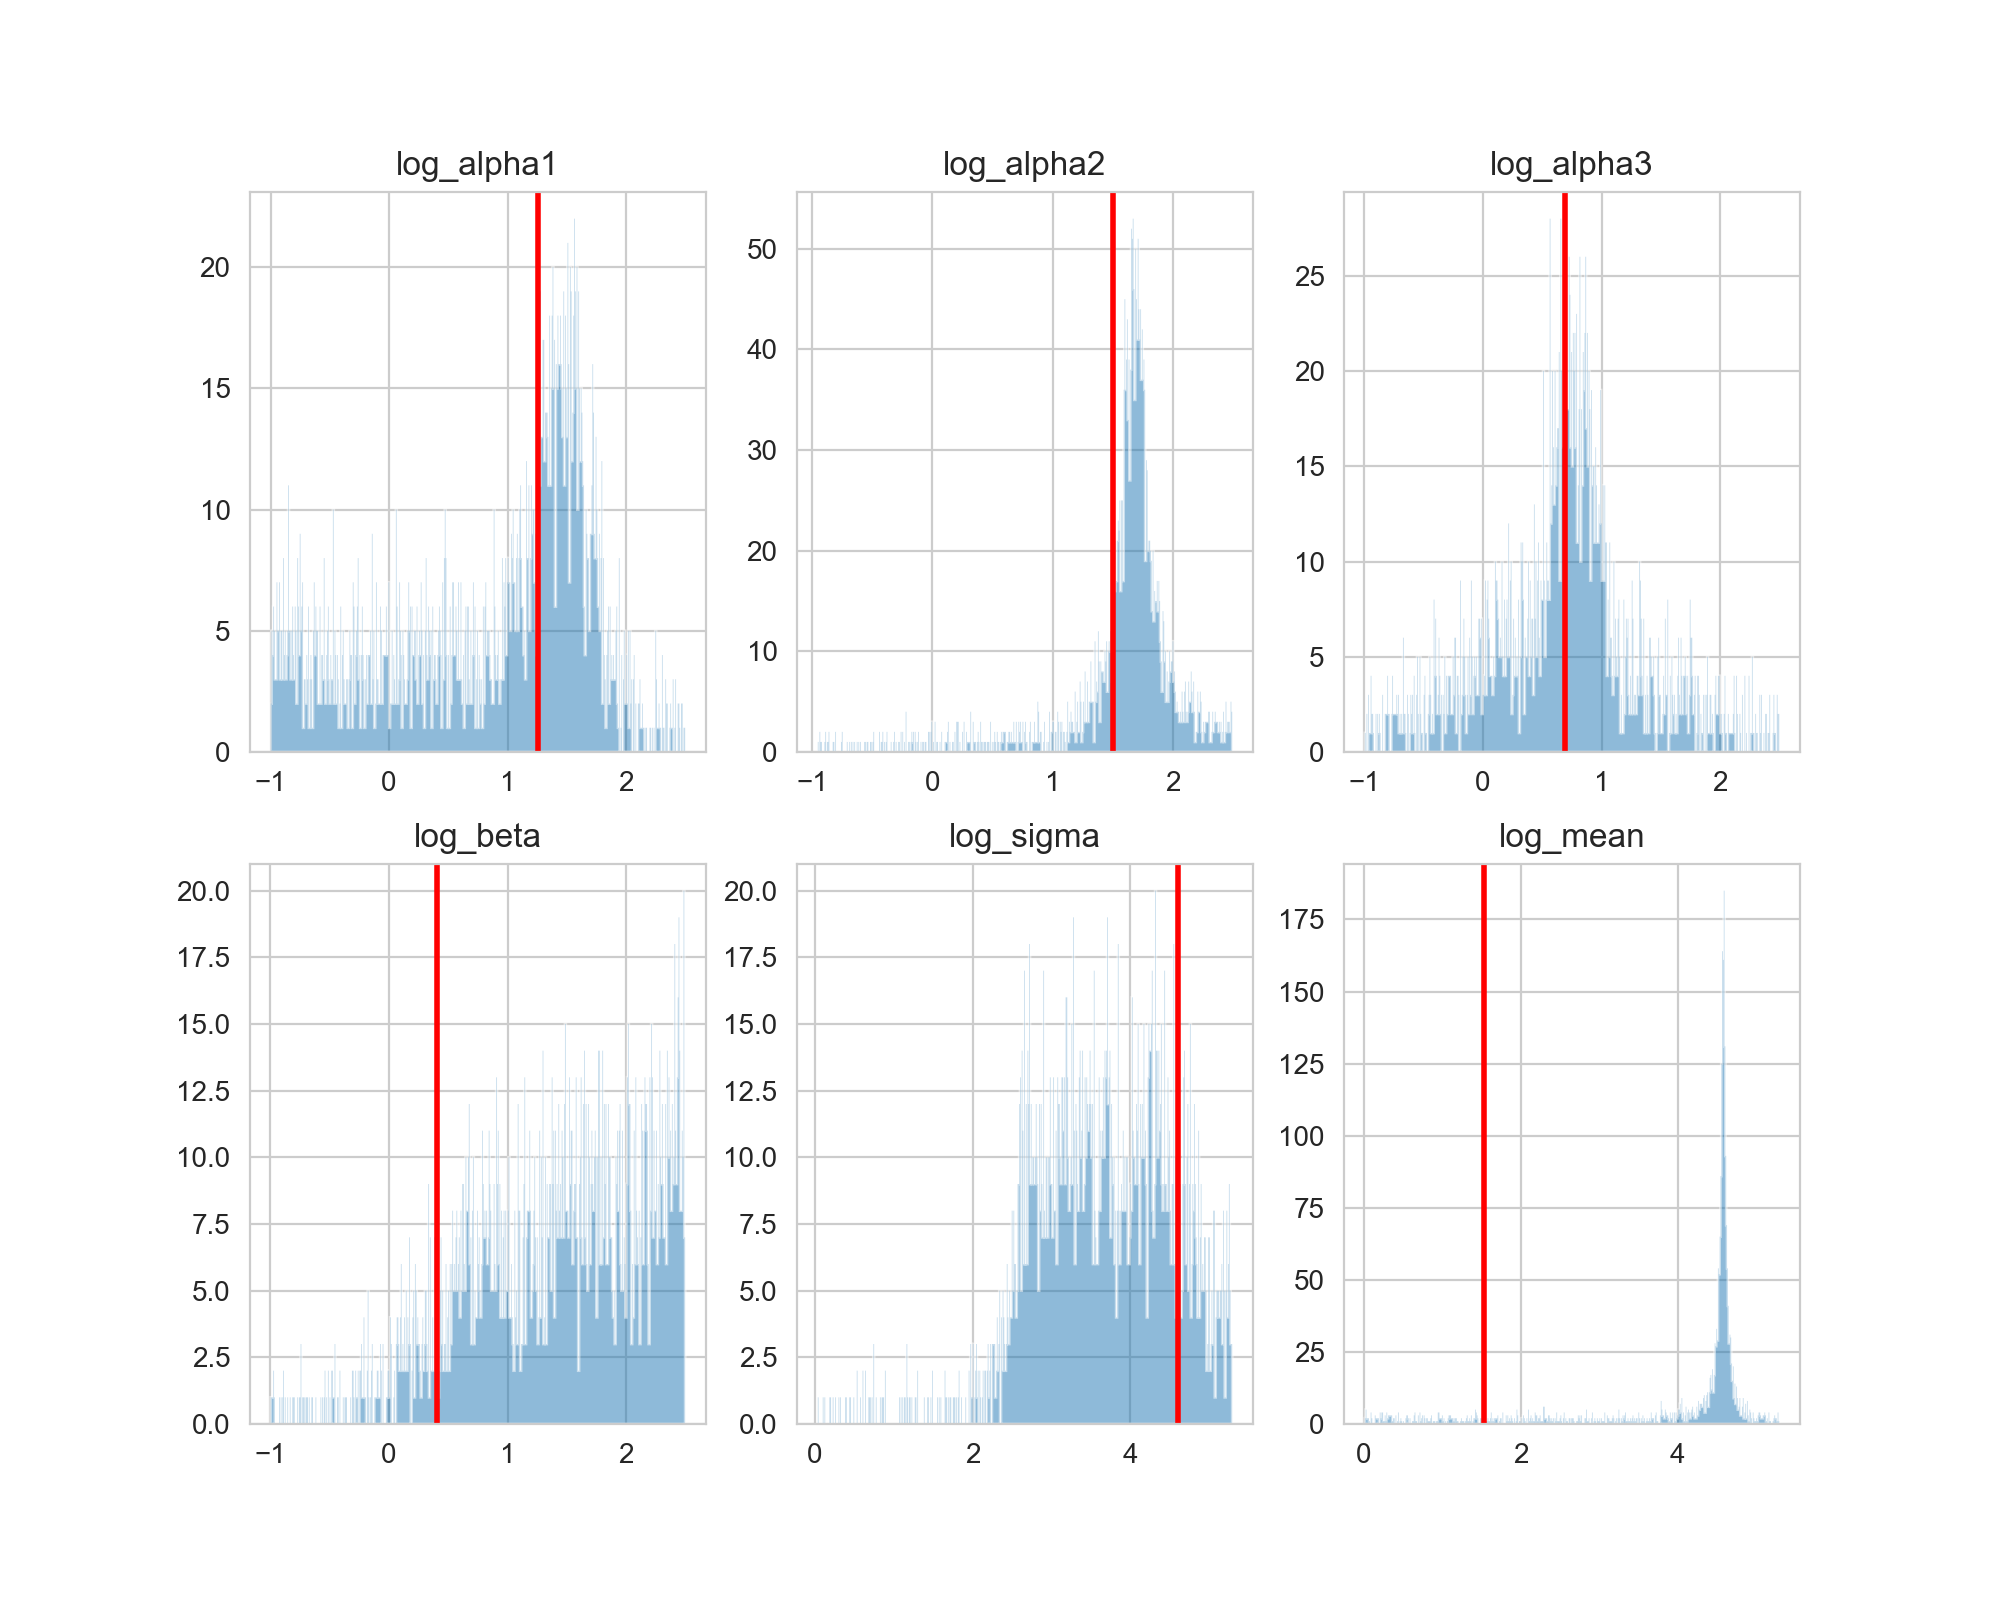

In [155]:
#samples = ns.get_samples(random.PRNGKey(3), num_samples=5000)

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

kernel_var_names = ["log_alpha1", "log_alpha2", "log_alpha3",
                    "log_beta", "log_sigma", "log_mean"]

axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=500, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

<IPython.core.display.Javascript object>


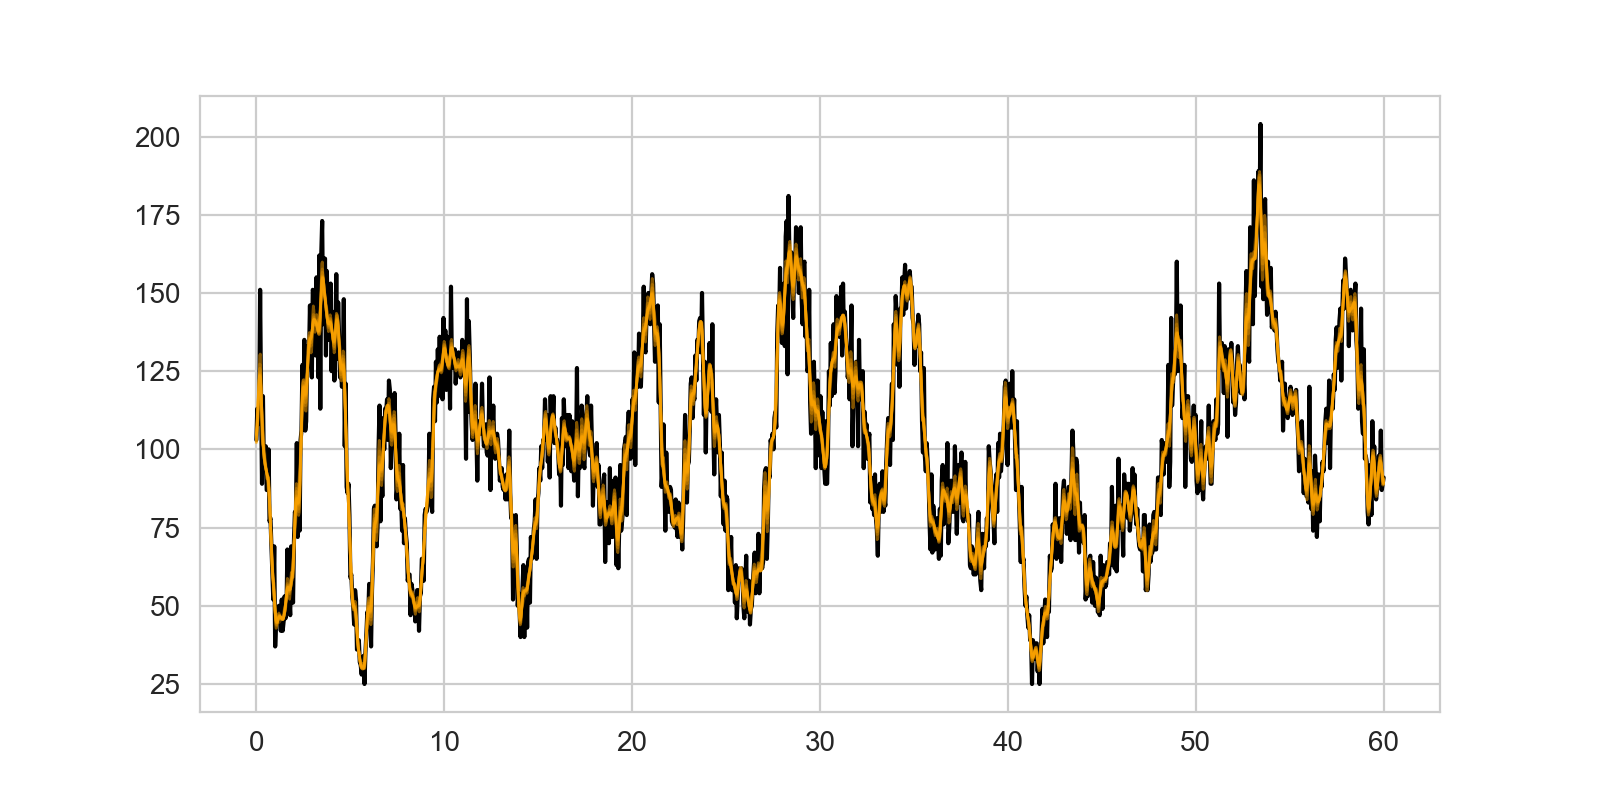

137.65023073355565
[Array(0.44166282, dtype=float64), Array(6.02404266, dtype=float64), Array(0.63877973, dtype=float64)]
107.63464248830252
[Array(1.61024589, dtype=float64), Array(1.04059802, dtype=float64), Array(1.98081326, dtype=float64)]
6.285073600683018
[Array(0.65101505, dtype=float64), Array(1.20309175, dtype=float64), Array(7.39335032, dtype=float64)]
98.3843398202666
[Array(4.6526846, dtype=float64), Array(5.50412072, dtype=float64), Array(2.46354863, dtype=float64)]
89.42553410399519
[Array(3.627837, dtype=float64), Array(5.51047407, dtype=float64), Array(2.37113155, dtype=float64)]
93.74430164183963
[Array(6.7964826, dtype=float64), Array(7.89661518, dtype=float64), Array(2.87582367, dtype=float64)]
96.85891171158154
[Array(3.44243099, dtype=float64), Array(5.01286712, dtype=float64), Array(1.70980097, dtype=float64)]
11.633263914598324
[Array(2.97616006, dtype=float64), Array(2.25760622, dtype=float64), Array(4.65705231, dtype=float64)]
104.65913484775062
[Array(0.741137

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lcsample.time[:npoints], lcsample.counts[:npoints], color="black")

nsims = 10
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

tpost = np.linspace(0.0, time[-1], 2000)

for idx in idx_all:
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx]),
             jnp.exp(samples["log_alpha3"][idx])]
    
    beta_post = jnp.exp(samples["log_beta"][idx])
    sigma_post = jnp.exp(samples["log_sigma"][idx])
    mean_post = jnp.exp(samples["log_mean"][idx])
    print(mean_post)
    
    print(alpha_post)
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post, 
                        sigma=sigma_post)
    
    gp = GaussianProcess(kernel_post, lcsample.time[:npoints], diag=0.01,
                         mean_value=jnp.ones_like(lcsample.time[:npoints])*mean_post)

    _, cond = gp.condition(lcsample.counts[:npoints], tpost, include_mean=True)

    ax.plot(tpost, cond.loc+mean_post, lw=1, color="orange", alpha=0.3)


## With a Mean Model

Let's add a mean model:

In [4]:
def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]
    logconst = params[4]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y + jnp.exp(logconst)

INFO[2023-10-07 18:40:15,833]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-07 18:40:15,834]: Checking if light curve is sorted.
INFO[2023-10-07 18:40:15,835]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-6796651.00738979


<IPython.core.display.Javascript object>


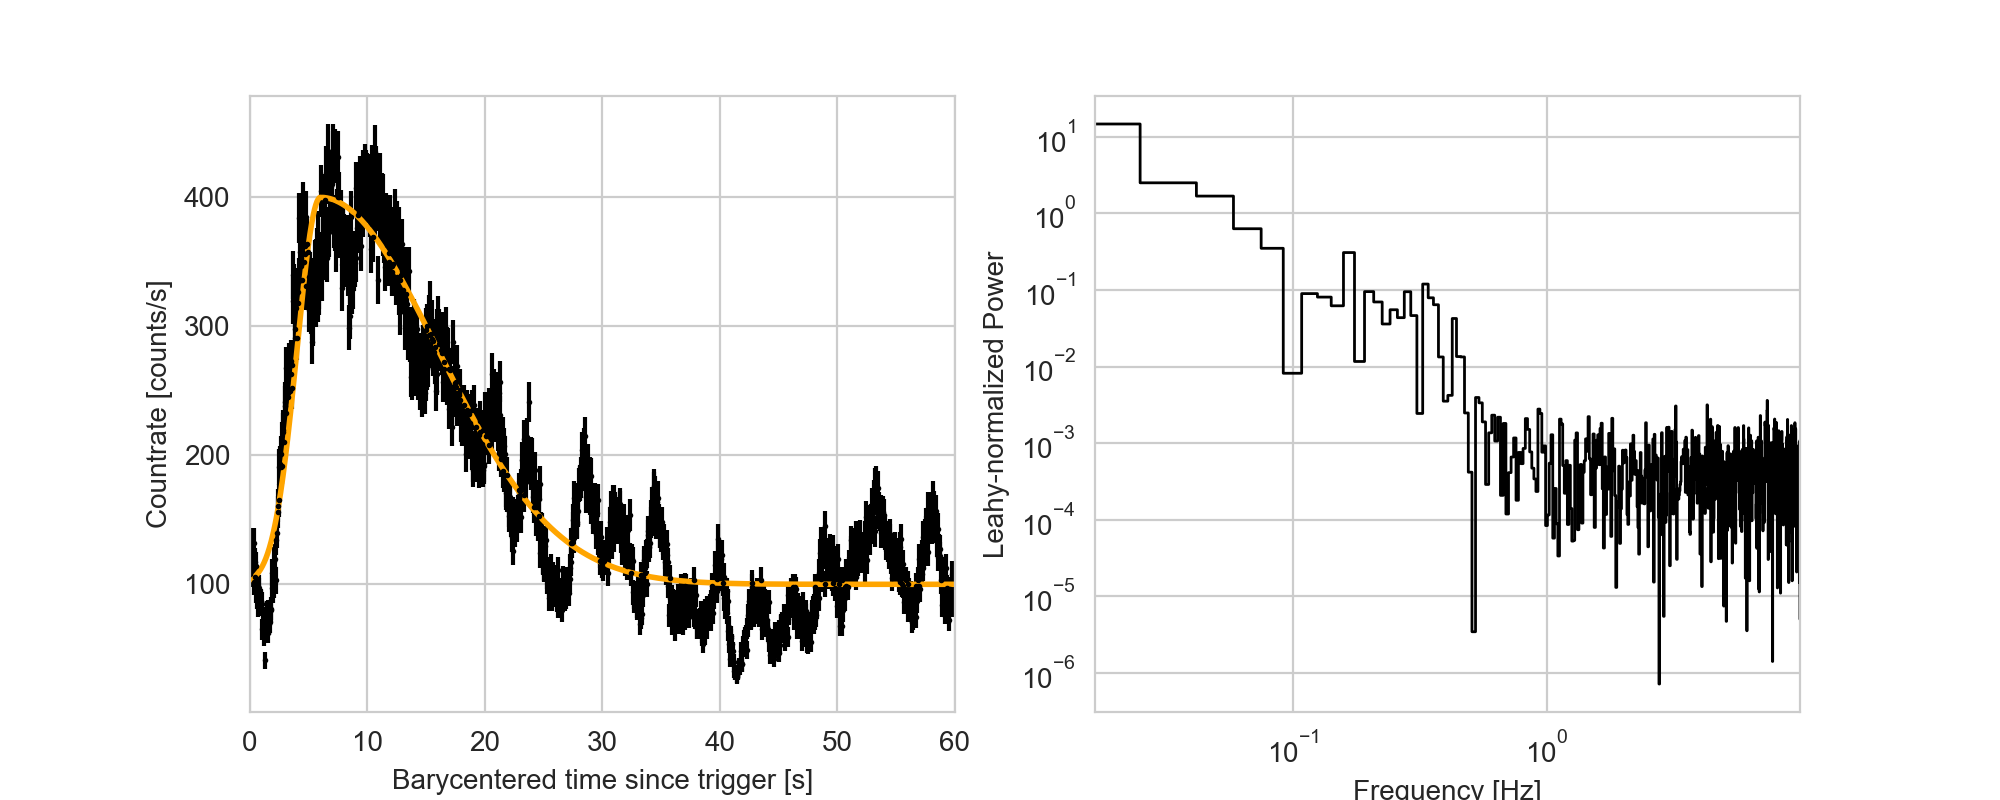

<IPython.core.display.Javascript object>


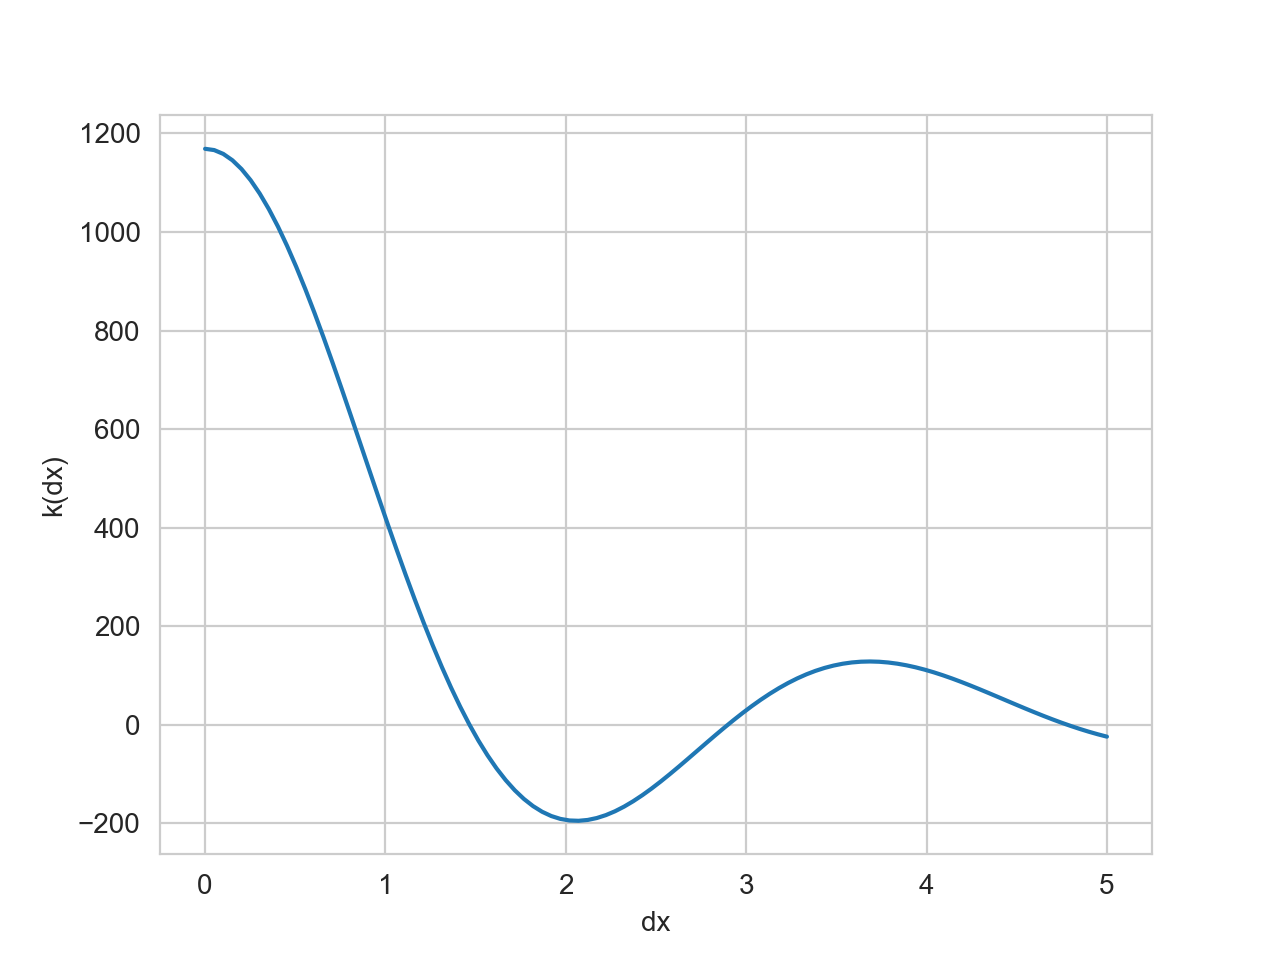

In [190]:
# Make a time array
dt = 0.05
tseg = 60.0

time = np.linspace(0, 60, int(60/0.05))

alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 100

skew_amp = 300
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0
const = 100.0


mean_params_true = [np.log(skew_amp),
               skew_t0,
               np.log(skew_sig1),
               np.log(skew_sig2),
               np.log(const)]


mean_val = skewgaussian(time, mean_params_true)

#kernel_params_true = {"alpha": alpha,
#                      "beta": beta,
#                      "acarma": sigma}

kernel_params_true = np.hstack([alpha, beta, sigma])

kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, time, diag=0.01)

key = random.PRNGKey(1200)
sample = gp.sample(key) + mean_val
sample = np.random.poisson(sample)

gp.condition(sample)
print(gp.log_probability(sample))

lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="frac")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.plot(time, mean_val, lw=2, color="orange")

ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

In [179]:
mean_params_true

[Array(5.70378247, dtype=float64, weak_type=True),
 6.0,
 Array(0.69314718, dtype=float64, weak_type=True),
 Array(2.30258509, dtype=float64, weak_type=True),
 Array(4.60517019, dtype=float64, weak_type=True)]

In [183]:
def model_with_mean(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(2, 7))
    t0 = numpyro.sample("t0", dist.Uniform(2, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3))
    log_const = numpyro.sample("log_const", dist.Uniform(3, 6))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-1, 2.5))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-1, 2.5))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-1, 2.5))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-1, 2.5))
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(0, 5.3))
    
    
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
                        beta=[jnp.exp(log_beta)], sigma=jnp.exp(log_sigma))
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [184]:
npoints = len(lcsample.time)
ns = NestedSampler(model_with_mean)
ns.run(random.PRNGKey(2), lcsample.time[:npoints], y=lcsample.counts[:npoints])

In [185]:
samples, weights = ns.get_weighted_samples()

ns.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 688539
# samples: 6750
# slices: 172500.0
# slices / acceptance: 30.0
# likelihood evals / sample: 102.0
# likelihood evals / slice: 3.9
--------
logZ=-4895.9 +- 0.25
H=4900.0
ESS=1268
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 0.54 +- 0.7 | -0.42 / 0.56 / 1.4 | 1.19 | 1.19
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 1.65 +- 0.13 | 1.51 / 1.63 / 1.82 | 1.67 | 1.67
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 0.24 +- 0.43 | -0.28 / 0.2 / 0.75 | 0.54 | 0.54
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 5.65 +- 0.1 | 5.52 / 5.65 / 5.75 | 5.65 | 5.65
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 1.2 +- 0.76 | 0.18 / 1.23 / 2.2 | 2.0 

pred[138]: 38.0 +- 26.0 | 9.0 / 36.0 / 70.0 | 32.0 | 32.0
pred[139]: 38.0 +- 26.0 | 10.0 / 36.0 / 71.0 | 33.0 | 33.0
pred[140]: 39.0 +- 26.0 | 9.0 / 36.0 / 71.0 | 33.0 | 33.0
pred[141]: 38.0 +- 26.0 | 9.0 / 36.0 / 71.0 | 33.0 | 33.0
pred[142]: 38.0 +- 26.0 | 9.0 / 36.0 / 71.0 | 32.0 | 32.0
pred[143]: 37.0 +- 26.0 | 8.0 / 35.0 / 70.0 | 32.0 | 32.0
pred[144]: 36.0 +- 26.0 | 7.0 / 33.0 / 68.0 | 30.0 | 30.0
pred[145]: 34.0 +- 26.0 | 5.0 / 32.0 / 67.0 | 29.0 | 29.0
pred[146]: 33.0 +- 26.0 | 4.0 / 30.0 / 65.0 | 27.0 | 27.0
pred[147]: 30.0 +- 26.0 | 1.0 / 28.0 / 63.0 | 25.0 | 25.0
pred[148]: 28.0 +- 26.0 | -1.0 / 26.0 / 61.0 | 23.0 | 23.0
pred[149]: 26.0 +- 26.0 | -3.0 / 23.0 / 58.0 | 20.0 | 20.0
pred[150]: 23.0 +- 26.0 | -6.0 / 21.0 / 55.0 | 18.0 | 18.0
pred[151]: 20.0 +- 26.0 | -9.0 / 18.0 / 52.0 | 15.0 | 15.0
pred[152]: 17.0 +- 26.0 | -12.0 / 15.0 / 49.0 | 12.0 | 12.0
pred[153]: 14.0 +- 26.0 | -14.0 / 12.0 / 46.0 | 9.0 | 9.0
pred[154]: 11.0 +- 26.0 | -17.0 / 9.0 / 43.0 | 6.0 | 6.0
pred[155

pred[311]: 20.0 +- 21.0 | -3.0 / 19.0 / 44.0 | 17.0 | 17.0
pred[312]: 20.0 +- 21.0 | -2.0 / 19.0 / 45.0 | 18.0 | 18.0
pred[313]: 21.0 +- 21.0 | -2.0 / 19.0 / 45.0 | 18.0 | 18.0
pred[314]: 20.0 +- 21.0 | -2.0 / 19.0 / 44.0 | 18.0 | 18.0
pred[315]: 20.0 +- 21.0 | -2.0 / 19.0 / 44.0 | 17.0 | 17.0
pred[316]: 19.0 +- 21.0 | -3.0 / 18.0 / 44.0 | 17.0 | 17.0
pred[317]: 19.0 +- 21.0 | -4.0 / 17.0 / 43.0 | 16.0 | 16.0
pred[318]: 18.0 +- 21.0 | -5.0 / 17.0 / 42.0 | 15.0 | 15.0
pred[319]: 17.0 +- 21.0 | -6.0 / 15.0 / 41.0 | 14.0 | 14.0
pred[320]: 16.0 +- 21.0 | -7.0 / 14.0 / 40.0 | 13.0 | 13.0
pred[321]: 14.0 +- 21.0 | -9.0 / 13.0 / 39.0 | 12.0 | 12.0
pred[322]: 13.0 +- 21.0 | -10.0 / 12.0 / 38.0 | 11.0 | 11.0
pred[323]: 12.0 +- 21.0 | -11.0 / 11.0 / 37.0 | 9.0 | 9.0
pred[324]: 10.0 +- 21.0 | -13.0 / 9.0 / 35.0 | 8.0 | 8.0
pred[325]: 9.0 +- 21.0 | -14.0 / 8.0 / 34.0 | 7.0 | 7.0
pred[326]: 8.0 +- 21.0 | -16.0 / 7.0 / 33.0 | 5.0 | 5.0
pred[327]: 7.0 +- 21.0 | -17.0 / 5.0 / 32.0 | 4.0 | 4.0
pred[328

pred[450]: -34.0 +- 22.0 | -61.0 / -34.0 / -8.0 | -34.0 | -34.0
pred[451]: -32.0 +- 22.0 | -59.0 / -32.0 / -7.0 | -33.0 | -33.0
pred[452]: -31.0 +- 22.0 | -58.0 / -31.0 / -5.0 | -31.0 | -31.0
pred[453]: -29.0 +- 22.0 | -56.0 / -29.0 / -3.0 | -29.0 | -29.0
pred[454]: -26.0 +- 22.0 | -53.0 / -26.0 / -0.0 | -26.0 | -26.0
pred[455]: -24.0 +- 22.0 | -50.0 / -24.0 / 2.0 | -24.0 | -24.0
pred[456]: -21.0 +- 22.0 | -47.0 / -21.0 / 5.0 | -21.0 | -21.0
pred[457]: -17.0 +- 22.0 | -44.0 / -17.0 / 8.0 | -18.0 | -18.0
pred[458]: -14.0 +- 22.0 | -41.0 / -14.0 / 11.0 | -14.0 | -14.0
pred[459]: -11.0 +- 22.0 | -37.0 / -10.0 / 15.0 | -11.0 | -11.0
pred[460]: -7.0 +- 22.0 | -34.0 / -7.0 / 18.0 | -7.0 | -7.0
pred[461]: -3.0 +- 22.0 | -30.0 / -3.0 / 22.0 | -3.0 | -3.0
pred[462]: 0.0 +- 22.0 | -27.0 / 1.0 / 26.0 | 0.0 | 0.0
pred[463]: 4.0 +- 22.0 | -23.0 / 4.0 / 29.0 | 4.0 | 4.0
pred[464]: 8.0 +- 22.0 | -19.0 / 8.0 / 33.0 | 7.0 | 7.0
pred[465]: 11.0 +- 22.0 | -16.0 / 11.0 / 36.0 | 11.0 | 11.0
pred[466]: 14.0

pred[595]: 2.0 +- 17.0 | -19.0 / 3.0 / 20.0 | 3.0 | 3.0
pred[596]: 0.0 +- 17.0 | -20.0 / 2.0 / 18.0 | 1.0 | 1.0
pred[597]: -1.0 +- 17.0 | -22.0 / 0.0 / 16.0 | -1.0 | -1.0
pred[598]: -2.0 +- 17.0 | -23.0 / -1.0 / 15.0 | -2.0 | -2.0
pred[599]: -3.0 +- 17.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[600]: -4.0 +- 17.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[601]: -4.0 +- 17.0 | -24.0 / -3.0 / 14.0 | -4.0 | -4.0
pred[602]: -4.0 +- 16.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[603]: -3.0 +- 16.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[604]: -2.0 +- 16.0 | -23.0 / -1.0 / 15.0 | -2.0 | -2.0
pred[605]: -1.0 +- 16.0 | -21.0 / 0.0 / 16.0 | -1.0 | -1.0
pred[606]: 1.0 +- 16.0 | -20.0 / 2.0 / 18.0 | 1.0 | 1.0
pred[607]: 3.0 +- 16.0 | -18.0 / 4.0 / 20.0 | 3.0 | 3.0
pred[608]: 5.0 +- 16.0 | -16.0 / 6.0 / 22.0 | 5.0 | 5.0
pred[609]: 7.0 +- 16.0 | -14.0 / 8.0 / 24.0 | 7.0 | 7.0
pred[610]: 9.0 +- 16.0 | -11.0 / 11.0 / 26.0 | 10.0 | 10.0
pred[611]: 12.0 +- 16.0 | -9.0 / 13.0 / 29.0 | 12.0 | 12.0
pred[612

pred[742]: -10.0 +- 14.0 | -26.0 / -10.0 / 7.0 | -12.0 | -12.0
pred[743]: -9.0 +- 14.0 | -25.0 / -9.0 / 7.0 | -11.0 | -11.0
pred[744]: -8.0 +- 14.0 | -25.0 / -9.0 / 8.0 | -10.0 | -10.0
pred[745]: -8.0 +- 14.0 | -24.0 / -8.0 / 8.0 | -10.0 | -10.0
pred[746]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -9.0 | -9.0
pred[747]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -9.0 | -9.0
pred[748]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -9.0 | -9.0
pred[749]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -10.0 | -10.0
pred[750]: -8.0 +- 14.0 | -25.0 / -8.0 / 8.0 | -10.0 | -10.0
pred[751]: -9.0 +- 14.0 | -25.0 / -9.0 / 8.0 | -10.0 | -10.0
pred[752]: -9.0 +- 14.0 | -26.0 / -9.0 / 7.0 | -11.0 | -11.0
pred[753]: -10.0 +- 14.0 | -27.0 / -10.0 / 7.0 | -12.0 | -12.0
pred[754]: -11.0 +- 14.0 | -27.0 / -11.0 / 6.0 | -13.0 | -13.0
pred[755]: -12.0 +- 14.0 | -28.0 / -12.0 / 5.0 | -14.0 | -14.0
pred[756]: -13.0 +- 14.0 | -29.0 / -13.0 / 4.0 | -15.0 | -15.0
pred[757]: -14.0 +- 14.0 | -31.0 / -15.0 / 2.0 | -16.0 | -16.0
pred[758]: -16.0 +

pred[897]: -39.0 +- 15.0 | -57.0 / -40.0 / -20.0 | -43.0 | -43.0
pred[898]: -39.0 +- 15.0 | -57.0 / -40.0 / -20.0 | -43.0 | -43.0
pred[899]: -38.0 +- 15.0 | -56.0 / -39.0 / -19.0 | -42.0 | -42.0
pred[900]: -37.0 +- 15.0 | -55.0 / -38.0 / -18.0 | -41.0 | -41.0
pred[901]: -36.0 +- 15.0 | -54.0 / -37.0 / -17.0 | -40.0 | -40.0
pred[902]: -35.0 +- 15.0 | -53.0 / -36.0 / -16.0 | -39.0 | -39.0
pred[903]: -34.0 +- 15.0 | -52.0 / -35.0 / -15.0 | -38.0 | -38.0
pred[904]: -33.0 +- 15.0 | -51.0 / -34.0 / -14.0 | -37.0 | -37.0
pred[905]: -32.0 +- 15.0 | -50.0 / -33.0 / -12.0 | -36.0 | -36.0
pred[906]: -31.0 +- 15.0 | -49.0 / -32.0 / -11.0 | -35.0 | -35.0
pred[907]: -29.0 +- 16.0 | -48.0 / -31.0 / -10.0 | -34.0 | -34.0
pred[908]: -28.0 +- 16.0 | -46.0 / -29.0 / -8.0 | -32.0 | -32.0
pred[909]: -27.0 +- 16.0 | -45.0 / -28.0 / -7.0 | -31.0 | -31.0
pred[910]: -25.0 +- 16.0 | -43.0 / -27.0 / -6.0 | -30.0 | -30.0
pred[911]: -24.0 +- 16.0 | -42.0 / -25.0 / -4.0 | -28.0 | -28.0
pred[912]: -23.0 +- 16.0 | -4

pred[1072]: 68.0 +- 17.0 | 50.0 / 67.0 / 88.0 | 63.0 | 63.0
pred[1073]: 66.0 +- 17.0 | 48.0 / 65.0 / 87.0 | 61.0 | 61.0
pred[1074]: 64.0 +- 17.0 | 46.0 / 63.0 / 85.0 | 59.0 | 59.0
pred[1075]: 62.0 +- 17.0 | 44.0 / 61.0 / 82.0 | 57.0 | 57.0
pred[1076]: 60.0 +- 17.0 | 41.0 / 58.0 / 80.0 | 55.0 | 55.0
pred[1077]: 57.0 +- 17.0 | 39.0 / 56.0 / 77.0 | 52.0 | 52.0
pred[1078]: 55.0 +- 17.0 | 36.0 / 53.0 / 75.0 | 49.0 | 49.0
pred[1079]: 52.0 +- 17.0 | 34.0 / 50.0 / 72.0 | 47.0 | 47.0
pred[1080]: 49.0 +- 17.0 | 31.0 / 48.0 / 69.0 | 44.0 | 44.0
pred[1081]: 46.0 +- 17.0 | 28.0 / 45.0 / 66.0 | 41.0 | 41.0
pred[1082]: 44.0 +- 17.0 | 25.0 / 42.0 / 64.0 | 38.0 | 38.0
pred[1083]: 41.0 +- 17.0 | 23.0 / 40.0 / 61.0 | 36.0 | 36.0
pred[1084]: 39.0 +- 17.0 | 20.0 / 37.0 / 59.0 | 33.0 | 33.0
pred[1085]: 36.0 +- 17.0 | 18.0 / 35.0 / 56.0 | 31.0 | 31.0
pred[1086]: 34.0 +- 17.0 | 16.0 / 33.0 / 54.0 | 29.0 | 29.0
pred[1087]: 32.0 +- 17.0 | 14.0 / 31.0 / 52.0 | 27.0 | 27.0
pred[1088]: 30.0 +- 17.0 | 12.0 / 29.0 /

In [191]:
print(mean_params_true)

[5.703782474656201, 6.0, 0.6931471805599453, 2.302585092994046, 4.605170185988092]


<IPython.core.display.Javascript object>


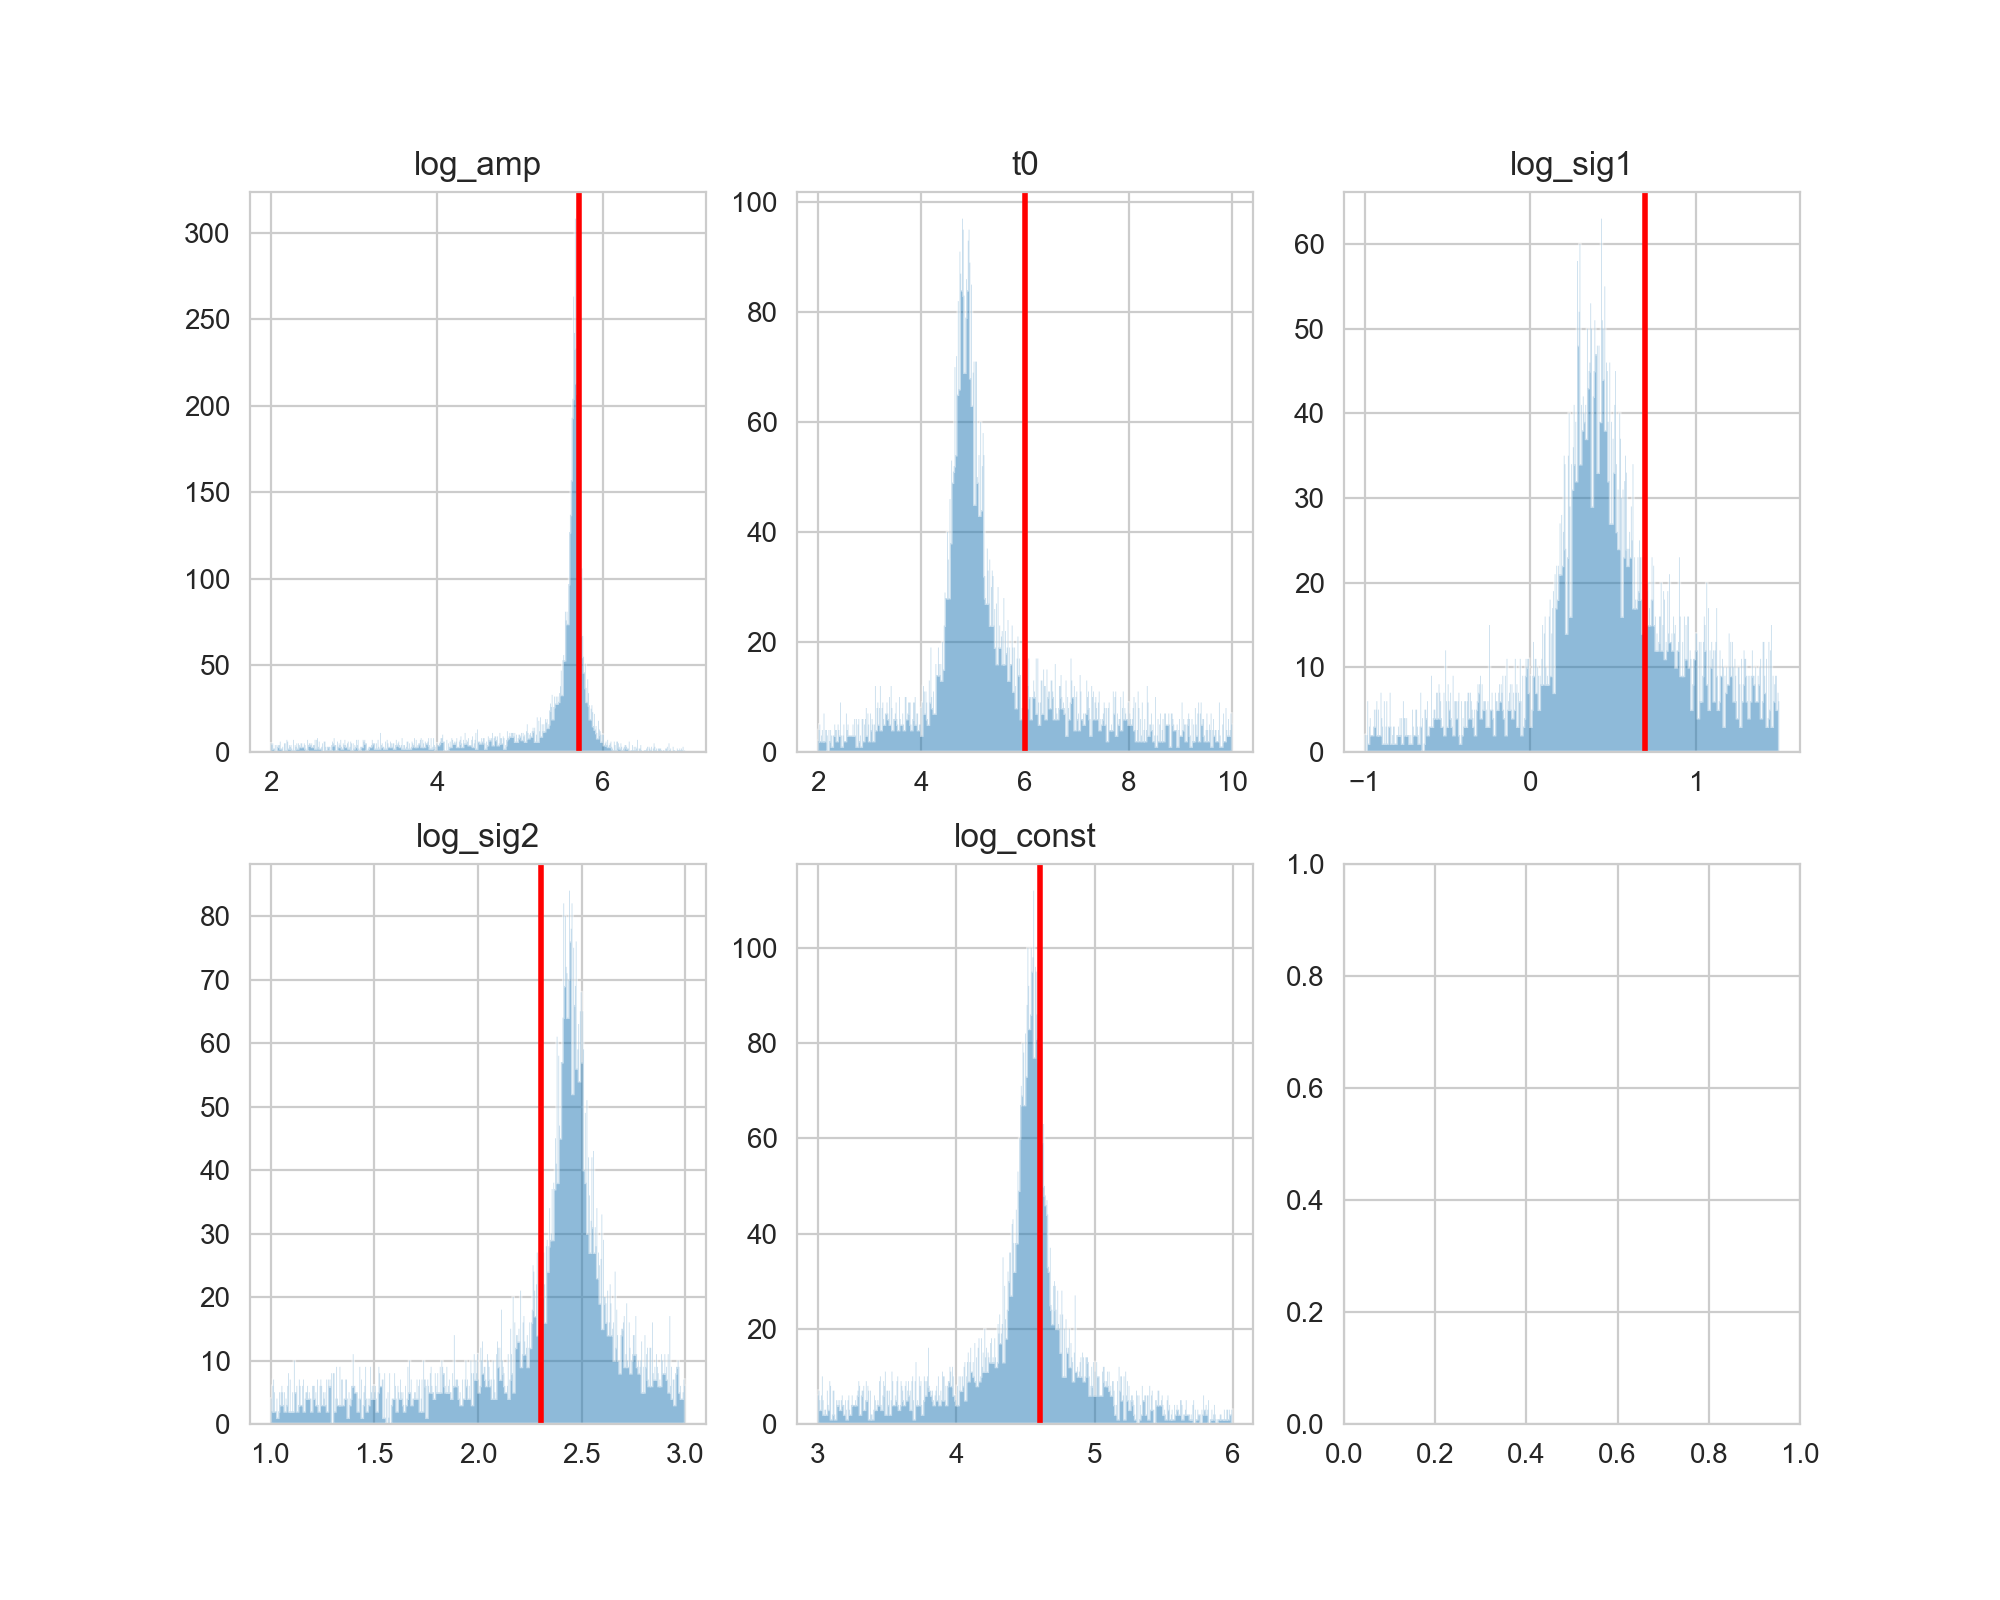

In [193]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=500, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


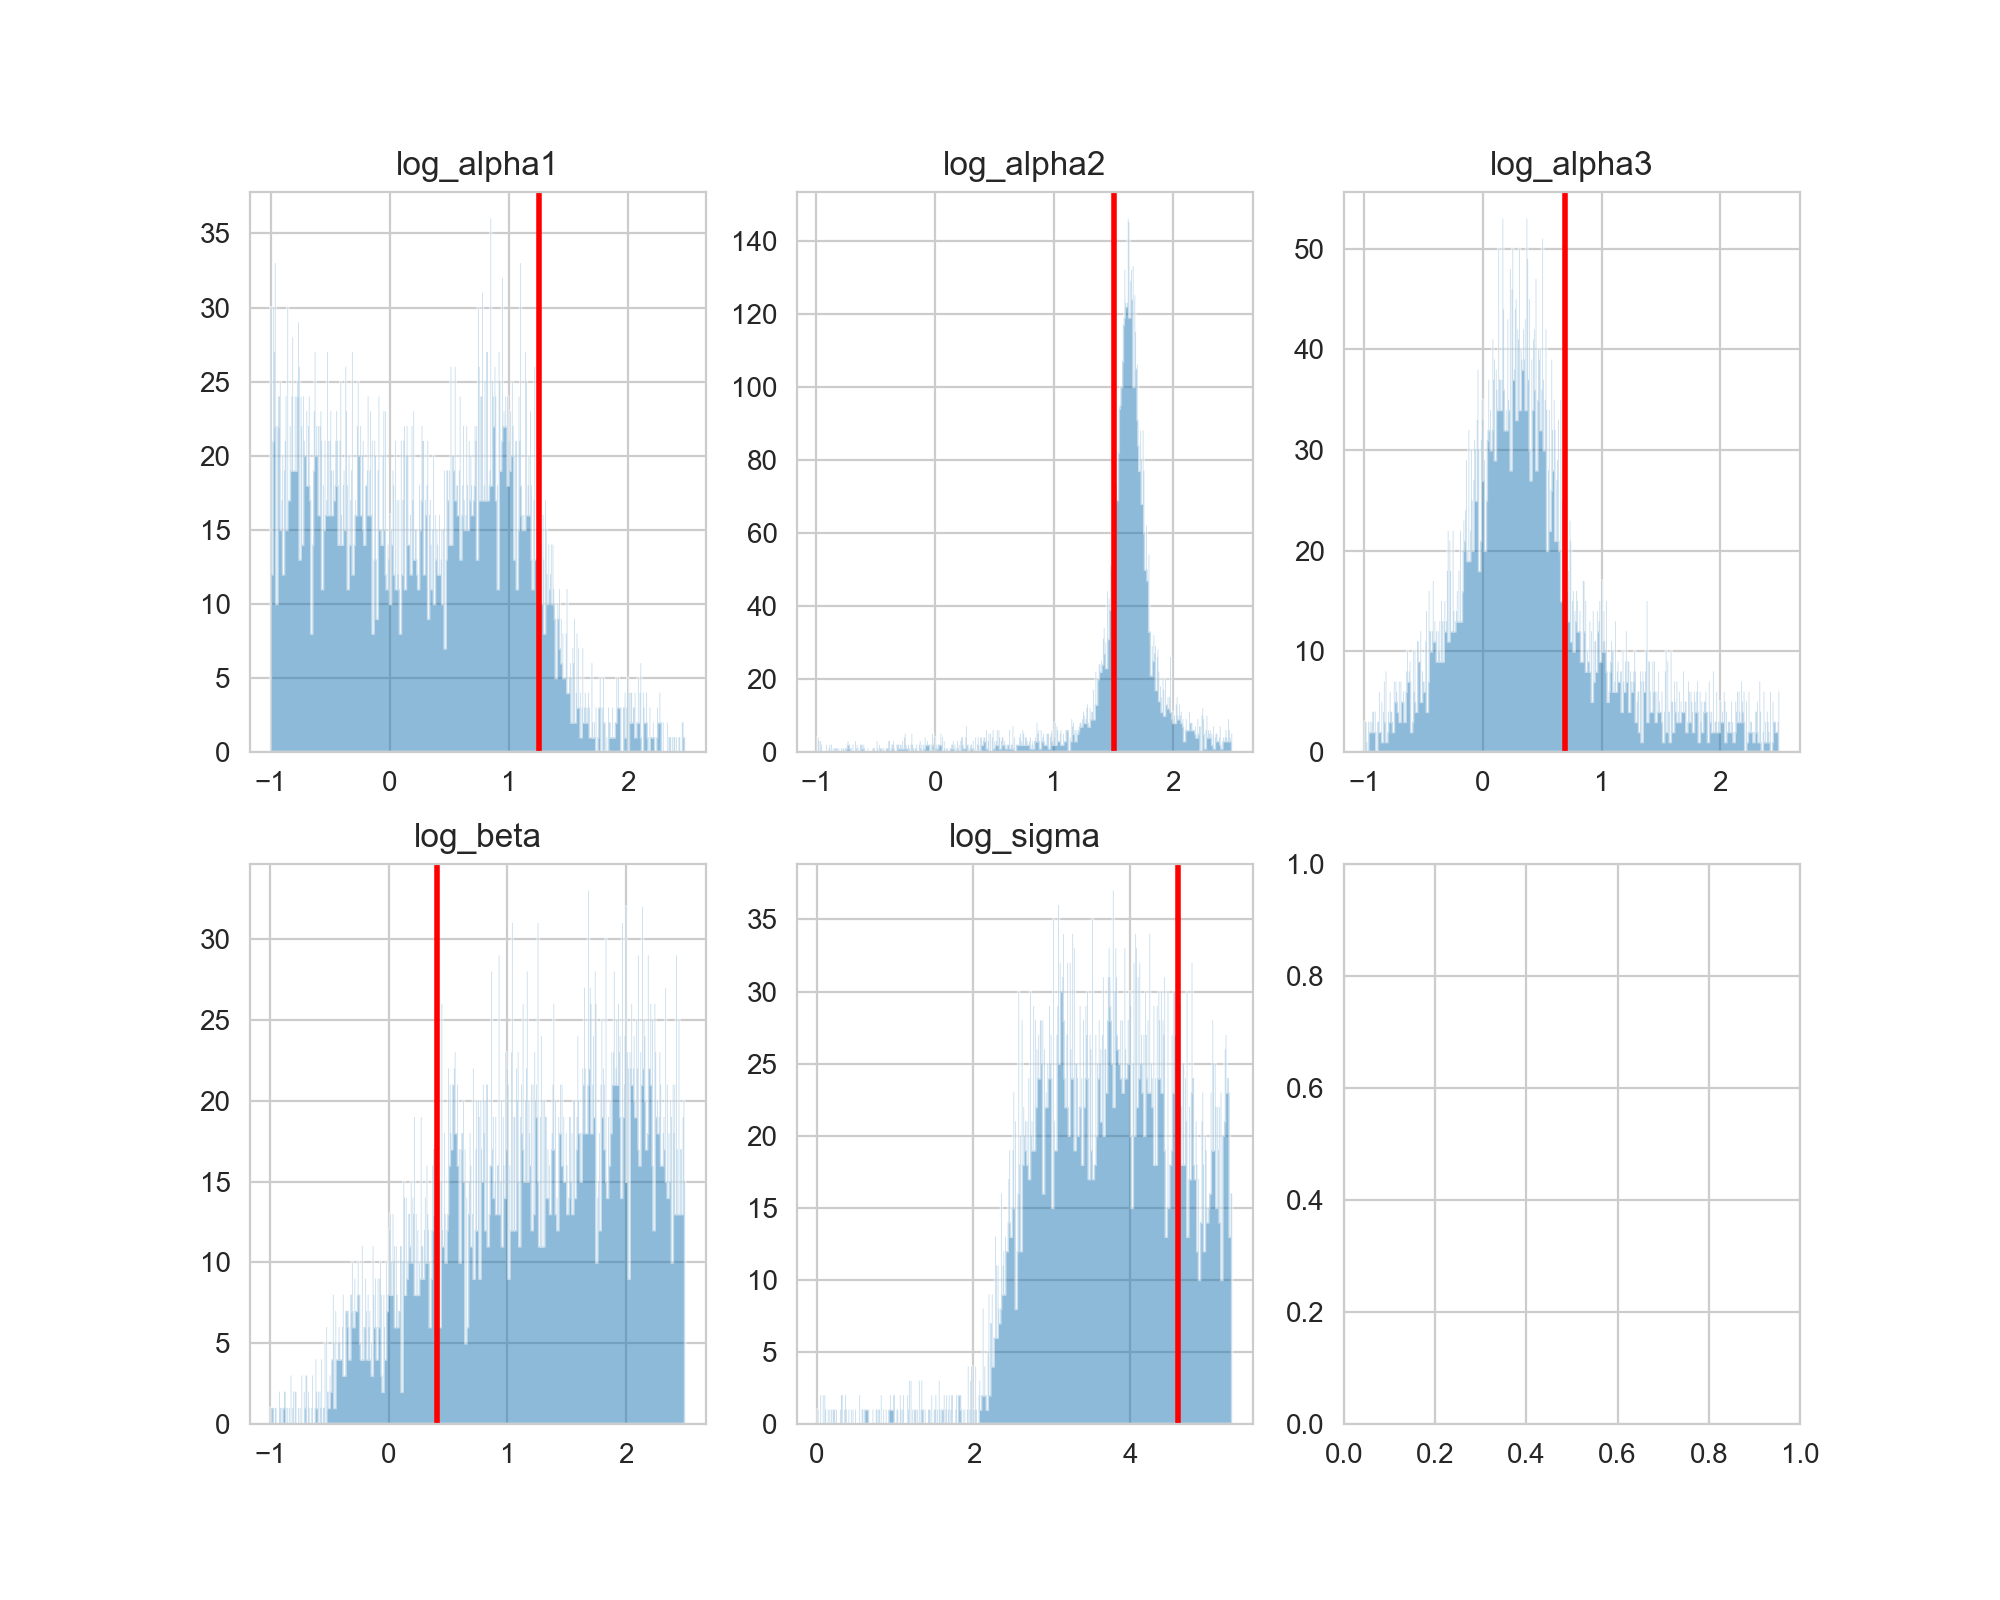

In [194]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_alpha3",
                    "log_beta", "log_sigma",]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=500, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [196]:
samples

{'log_alpha1': Array([0.39416905, 0.68852377, 2.37000999, ..., 1.30897347, 1.14222694,
        1.18896375], dtype=float64),
 'log_alpha2': Array([ 1.39685992, -0.29548761,  0.86740952, ...,  1.65098095,
         1.5941221 ,  1.66734568], dtype=float64),
 'log_alpha3': Array([1.00281436, 1.78354068, 2.22741914, ..., 0.59823035, 0.43912534,
        0.54435812], dtype=float64),
 'log_amp': Array([5.89090427, 6.52733343, 2.53466563, ..., 5.66227346, 5.66127077,
        5.6521354 ], dtype=float64),
 'log_beta': Array([-0.91461297,  0.20809224, -0.00235848, ...,  0.61523532,
         0.81242682,  1.99816167], dtype=float64),
 'log_const': Array([5.9930485 , 5.97041337, 5.96245001, ..., 4.52169234, 4.58395781,
        4.5634263 ], dtype=float64),
 'log_sig1': Array([ 0.34894001, -0.16933146, -0.11571412, ...,  0.3705944 ,
         0.29540562,  0.30789173], dtype=float64),
 'log_sig2': Array([2.70799866, 2.28475323, 1.17808052, ..., 2.43552414, 2.42036026,
        2.44703667], dtype=float64),


<IPython.core.display.Javascript object>


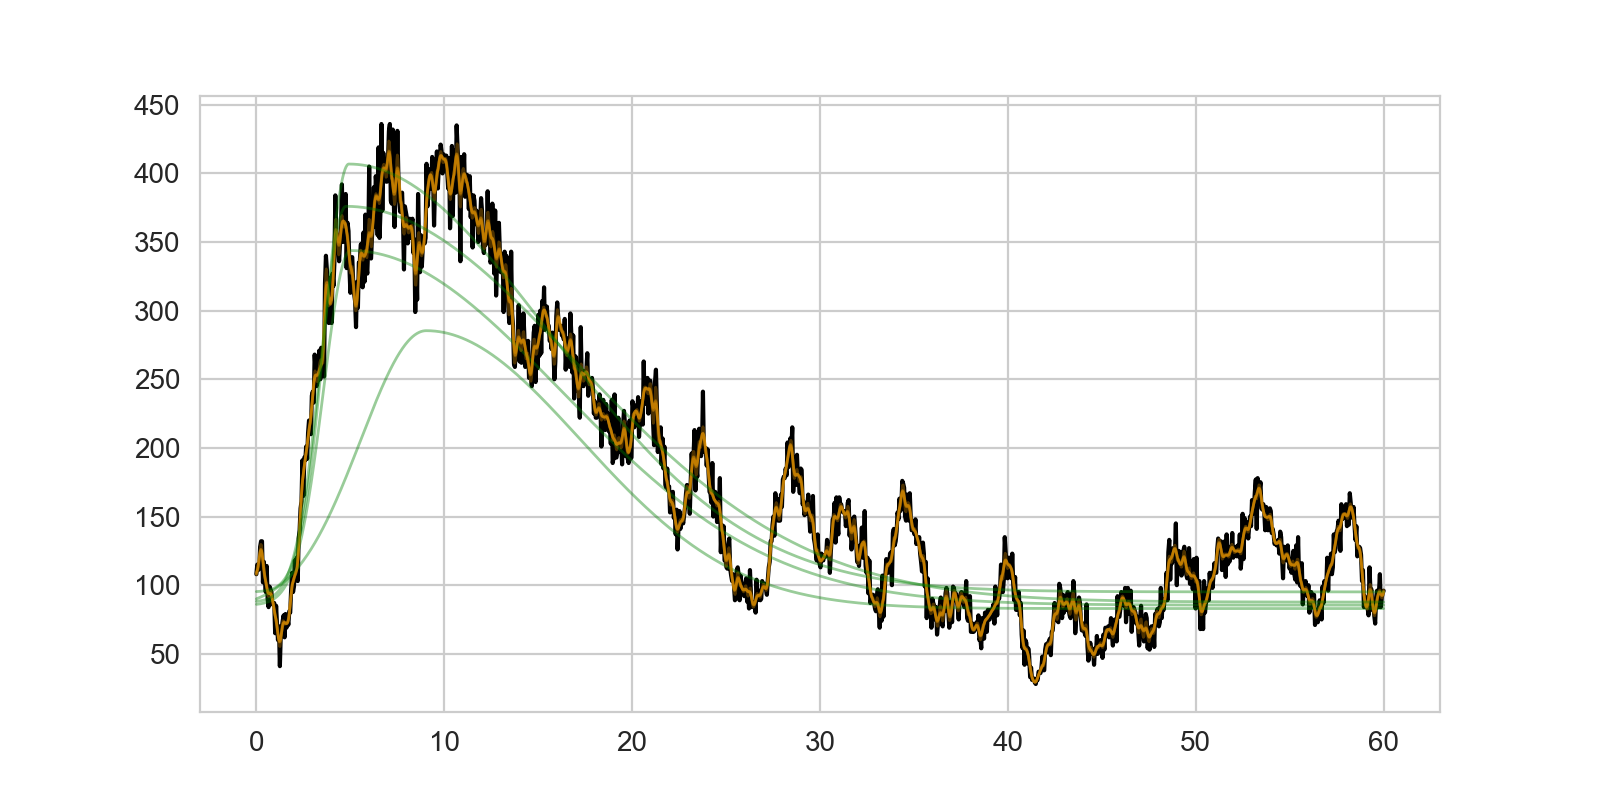

[Array(0.76278705, dtype=float64), Array(4.33842055, dtype=float64), Array(0.57979402, dtype=float64)]
[Array(0.76583726, dtype=float64), Array(4.548214, dtype=float64), Array(0.91863762, dtype=float64)]
[Array(8.67453728, dtype=float64), Array(7.24991653, dtype=float64), Array(4.05690967, dtype=float64)]
[Array(3.57801817, dtype=float64), Array(5.01278404, dtype=float64), Array(1.8055795, dtype=float64)]


In [201]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lcsample.time[:npoints], lcsample.counts[:npoints], color="black")

nsims = 4
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

tpost = np.linspace(0.0, time[-1], 2000)

for idx in idx_all:
    # mean parameters
    params = [samples["log_amp"][idx],
              samples["t0"][idx],
              samples["log_sig1"][idx],
              samples["log_sig2"][idx],
              samples["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx]),
             jnp.exp(samples["log_alpha3"][idx])]
    
    beta_post = jnp.exp(samples["log_beta"][idx])
    sigma_post = jnp.exp(samples["log_sigma"][idx])

    
    print(alpha_post)
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post, 
                        sigma=sigma_post)
    
    gp = GaussianProcess(kernel_post, lcsample.time[:npoints], diag=0.01)

    _, cond = gp.condition(lcsample.counts[:npoints], tpost, include_mean=True)

    ax.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.3)
    ax.plot(tpost, mean_post, lw=1, color="green", alpha=0.4)
